# Finite State Projection of a Gene Transmission Model

## Model

In this application example, we consider the two-stage model of gene transmission, discussed e.g. in. [[1]](#References). The two-stage model describes the stochastic transcription and translation of a gene by the reactions


\begin{align*}
R_1 &: \emptyset \to mRNA \\
R_2 &: mRNA \to \emptyset\\
R_3 &: mRNA \to mRNA + P \\
R_4 &: P \to \emptyset.
\end{align*}

The solution to the Chemical Master Equation (CME) [[2]](#References) gives the probabilities of the states at a given time point as the solution of an infinite dimensional ODE

\begin{align*}
\frac{d}{dt}x_{r, p} =& - \big(k_1 + (k_2+k_3) \cdot r + k_4 \cdot p \big) \cdot x_{r, p} \\
&+ k_1 \cdot x_{r-1, p} \\
&+ k_2 \cdot (r+1) \cdot x_{r+1, p} \\
&+ k_3 \cdot r \cdot x_{r, p-1} \\
&+ k_4 \cdot (p+1) \cdot x_{r, p+1}\\ 
\end{align*}

We assume the initial probabilites to be independent Poisson distributions for mRNA and Protein abundances.

## Finite State Projection

The Finite State Projection [[3]](#References) approximates this CME by restricting the states to a finite domain and approximating the probability of the left out states by zero. In our case, we ill restrict the states to $x_{r, p}$ for $(r, p) \in [0, r_{max}-1] \times [[0, p_{max}-1]]$.

## Model Construction:

The model is constructed using the `yaml2sbml` Model Editor and exported to SBML. This takes only a few lines of code: 

In [1]:
from yaml2sbml import YamlModel
from itertools import product
from scipy.stats import poisson

model = YamlModel()

r_max = 20
p_max = 50

lambda_r = 5
lambda_p = 5

# add parameters
model.add_parameter(parameter_id='k_1', nominal_value=2)
model.add_parameter(parameter_id='k_2', nominal_value=1)
model.add_parameter(parameter_id='k_3', nominal_value=10)
model.add_parameter(parameter_id='k_4', nominal_value=3)

# add ODEs & construct the rhs
for r, p in product(range(r_max), range(p_max)):
    
    rhs = f'-(k_1 + (k_2 + k_3)*{r} + k_4*{p}) * x_{r}_{p} '
    
    if r>0:
        rhs += f'+ k_1 * x_{r-1}_{p}'
    if r+1 < r_max:
        rhs += f'+ k_2 * {r+1} * x_{r+1}_{p}'
    if  p>0:
        rhs += f'+ k_3 * {r} * x_{r}_{p-1}'
    if p+1 < p_max:
        rhs += f'+ k_4 * {p+1} * x_{r}_{p+1}'
    
    model.add_ode(state_id = f"x_{r}_{p}", 
                  right_hand_side=rhs,
                  #convert from np.float to float
                  initial_value=float(poisson.pmf(r, lambda_r)*poisson.pmf(p, lambda_p))
                 )

model.write_to_sbml('gene_expression.xml', overwrite=True)

## Model Simulation

We now use AMICI to simulate the generated model and plot the marginal distributions of the mRNA and protein abundance.

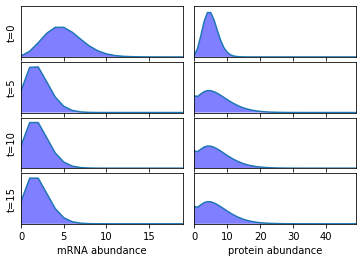

In [2]:
%matplotlib inline

import numpy as np
from utils import plot_AMICI

# sim, model = compile_and_simulate('gene_expression.xml', 0.1 * np.arange(10), r_max, p_max)

plot_AMICI('gene_expression.xml', [0, 5, 10, 15], r_max, p_max)

# References

[1] Shahrezaei, V.,  and Swain, P.S. (2008). "Analytical distributions for stochastic gene expression" PNAS 17256–17261 https://www.pnas.org/content/105/45/17256

[2] Gillespie, D. T. (1992). "A rigorous derivation of the chemical master equation" Physica A: Statistical Mechanics and its Applications https://www.sciencedirect.com/science/article/abs/pii/037843719290283V

[3] Munsky, B. and Khammash, M. (2006) "The finite state projection algorithm for the solution of the chemical master equation" The Journal of chemical physics https://aip.scitation.org/doi/full/10.1063/1.2145882